In [2]:
import math
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import matplotlib
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax


matplotlib.rcParams.update({"font.size": 30})

In [3]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)

In [4]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        )
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

In [6]:
def get_data(dataset_size, add_noise, *, key):
    theta_key, noise_key = jr.split(key, 2)
    length = 100
    theta = jr.uniform(theta_key, (dataset_size,), minval=0, maxval=2 * math.pi)
    y0 = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    ts = jnp.broadcast_to(jnp.linspace(0, 4 * math.pi, length), (dataset_size, length))
    matrix = jnp.array([[-0.3, 2], [-2, -0.3]])
    ys = jax.vmap(
        lambda y0i, ti: jax.vmap(lambda tij: jsp.linalg.expm(tij * matrix) @ y0i)(ti)
    )(y0, ts)
    ys = jnp.concatenate([ts[:, :, None], ys], axis=-1)  # time is a channel
    ys = ys.at[: dataset_size // 2, :, 1].multiply(-1)
    if add_noise:
        ys = ys + jr.normal(noise_key, ys.shape) * 0.1
    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(ts, ys)
    labels = jnp.zeros((dataset_size,))
    labels = labels.at[: dataset_size // 2].set(1.0)
    _, _, data_size = ys.shape
    return ts, coeffs, labels, data_size

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [29]:
def main(
    dataset_size=256,
    add_noise=False,
    batch_size=32,
    lr=1e-2,
    steps=20,
    hidden_size=8,
    width_size=128,
    depth=1,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

    ts, coeffs, labels, data_size = get_data(
        dataset_size, add_noise, key=train_data_key
    )

    model = NeuralCDE(data_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.

    @eqx.filter_jit
    def loss(model, ti, label_i, coeff_i):
        pred = jax.vmap(model)(ti, coeff_i)
        # Binary cross-entropy
        bxe = label_i * jnp.log(pred) + (1 - label_i) * jnp.log(1 - pred)
        bxe = -jnp.mean(bxe)
        acc = jnp.mean((pred > 0.5) == (label_i == 1))
        return bxe, acc

    grad_loss = eqx.filter_value_and_grad(loss, has_aux=True)

    @eqx.filter_jit
    def make_step(model, data_i, opt_state):
        ti, label_i, *coeff_i = data_i
        (bxe, acc), grads = grad_loss(model, ti, label_i, coeff_i)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return bxe, acc, model, opt_state

    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, data_i in zip(
        range(steps), dataloader((ts, labels) + coeffs, batch_size, key=loader_key)
    ):
        start = time.time()
        bxe, acc, model, opt_state = make_step(model, data_i, opt_state)
        end = time.time()
        print(
            f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

    ts, coeffs, labels, _ = get_data(dataset_size, add_noise, key=test_data_key)
    bxe, acc = loss(model, ts, labels, coeffs)
    print(f"Test loss: {bxe}, Test Accuracy: {acc}")

    # Plot results
    sample_ts = ts[-1]
    sample_coeffs = tuple(c[-1] for c in coeffs)
    pred = model(sample_ts, sample_coeffs, evolving_out=True)
    interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
    values = jax.vmap(interp.evaluate)(sample_ts)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
    ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
    ax1.plot(sample_ts, pred, c="crimson", label="Classification")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("t")
    ax1.legend()
    ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
    ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Classification")
    plt.tight_layout()
    plt.savefig("neural_cde.png")
    plt.show()

Step: 0, Loss: 2.519655704498291, Accuracy: 0.5, Computation time: 6.9318389892578125
Step: 1, Loss: 4.668292045593262, Accuracy: 0.5, Computation time: 0.16601085662841797
Step: 2, Loss: 1.9722990989685059, Accuracy: 0.46875, Computation time: 0.1332850456237793
Step: 3, Loss: 0.9076113700866699, Accuracy: 0.375, Computation time: 0.1262209415435791
Step: 4, Loss: 0.5399367809295654, Accuracy: 0.9375, Computation time: 0.11508679389953613
Step: 5, Loss: 0.6095027923583984, Accuracy: 0.53125, Computation time: 0.11101579666137695
Step: 6, Loss: 0.5813990831375122, Accuracy: 0.5, Computation time: 0.12129998207092285
Step: 7, Loss: 0.5064687728881836, Accuracy: 0.625, Computation time: 0.13171124458312988
Step: 8, Loss: 0.37394142150878906, Accuracy: 0.78125, Computation time: 0.1164243221282959
Step: 9, Loss: 0.34595441818237305, Accuracy: 0.90625, Computation time: 0.12739181518554688
Step: 10, Loss: 0.26510104537010193, Accuracy: 0.96875, Computation time: 0.12513494491577148
Step: 1

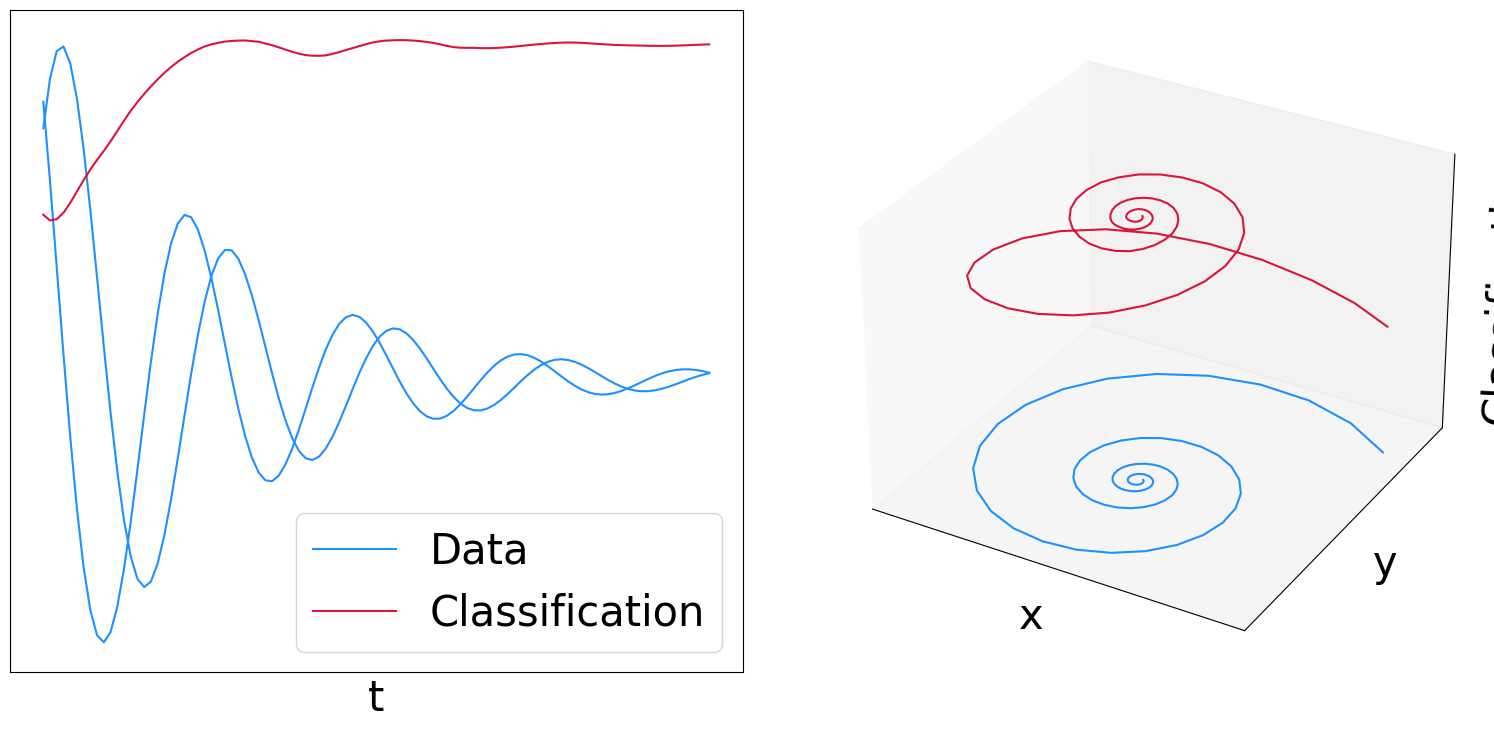

In [30]:
main()

In [11]:

dataset_size=256
add_noise=False
batch_size=32
lr=1e-2
steps=20
hidden_size=8
width_size=128
depth=1
seed=5678

key = jr.PRNGKey(seed)
train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

ts, coeffs, labels, data_size = get_data(
    dataset_size, add_noise, key=train_data_key
)



In [14]:
import pandas as pd

In [15]:
dft = pd.DataFrame(ts)

In [16]:
dft

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
1,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
2,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
3,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
4,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
252,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
253,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371
254,0.0,0.126933,0.253866,0.380799,0.507732,0.634665,0.761598,0.888531,1.015464,1.142397,...,11.423973,11.550906,11.677839,11.804772,11.931705,12.058639,12.185572,12.312505,12.439438,12.566371


In [17]:
ts.shape

(256, 100)

In [21]:
len(coeffs)

4

In [22]:
coeffs[0].shape

(256, 99, 3)

In [23]:
coeffs[1].shape

(256, 99, 3)

In [25]:
coeffs[0]

Array([[[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -2.8957533e+01, -1.0654022e+01],
        [-0.0000000e+00, -2.4406391e+01, -1.6928144e+01],
        ...,
        [-0.0000000e+00, -6.5302151e-01,  5.1009041e-01],
        [-0.0000000e+00, -7.3182184e-01,  3.1747559e-01],
        [-0.0000000e+00, -7.5867677e-01,  1.1890100e-01]],

       [[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00, -7.4399724e+00, -2.9944828e+01],
        [-0.0000000e+00,  3.0711642e-01, -2.9700920e+01],
        ...,
        [-0.0000000e+00, -7.8872645e-01, -2.5404325e-01],
        [-0.0000000e+00, -6.7356944e-01, -4.2738196e-01],
        [-0.0000000e+00, -5.2431566e-01, -5.6109834e-01]],

       [[-0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
        [-0.0000000e+00,  2.6352585e+01, -1.6049509e+01],
        [-0.0000000e+00,  2.8435148e+01, -8.5836554e+00],
        ...,
        [-0.0000000e+00,  6.7060729e-03, -8.2860512e-01],
        [-0.0000000e+00,  2.0

In [26]:
data_size

3

In [27]:
labels

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
len(labels)

256